In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# PyTorch model and training necessities
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Subset
from torch.utils.data import DataLoader

# Image datasets and image manipulation
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter

# Loading and Preprocessing the Data

In [2]:
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=True, 
                                           transform=transform, 
                                           download=True)

mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000)) 
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))
mnist_test_dataset = torchvision.datasets.MNIST(root=image_path, 
                                           train=False, 
                                           transform=transform, 
                                           download=False)

100%|█| 9912422/9912422 [00:01<00:00, 74


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|█| 28881/28881 [00:00<00:00, 437455

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|█| 1648877/1648877 [00:00<00:00, 39


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|█| 4542/4542 [00:00<00:00, 10415816

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [3]:
batch_size = 64
torch.manual_seed(43)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=True)

# Data Visualization

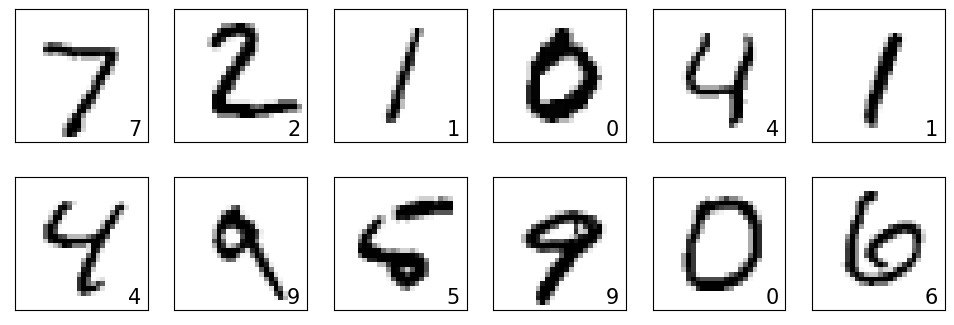

In [4]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    label = mnist_test_dataset[i][1]
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, label, 
            size=15, color='black',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    
plt.show()

# LeNet-5

<img src="lenet5.png">

*Figure: LeNet-5*

Above is a diagram of LeNet-5, one of the earliest convolutional neural nets, and one of the drivers of the explosion in Deep Learning. It was built to read small images of handwritten numbers (the MNIST dataset), and correctly classify which digit was represented in the image. We shall use almost the same architecture to train a model on the same dataset.


In [5]:
class LeNet(nn.Module):

    def __init__(self):
        super(LeNet, self).__init__()
        # Covolution layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        # affine layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512)  
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x)) 
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [6]:
model = LeNet()
print(model)                         

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


## Training

In [7]:
logdir = 'runs/MNIST'

writer = SummaryWriter(logdir)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch 
            y_batch = y_batch
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)
        
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch 
                y_batch = y_batch
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0) 
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float() 
                accuracy_hist_valid[epoch] += is_correct.sum()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        writer.add_scalars('Training vs. Validation Loss',
                            { 'Training' : loss_hist_train[epoch], 'Validation' : loss_hist_valid[epoch] },
                            epoch)
        writer.add_scalars('Training vs. Validation Accuracy',
                            { 'Training' : accuracy_hist_train[epoch], 'Validation' : accuracy_hist_valid[epoch] },
                            epoch)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.9270 val_accuracy: 0.9676
Epoch 2 accuracy: 0.9737 val_accuracy: 0.9771
Epoch 3 accuracy: 0.9801 val_accuracy: 0.9809
Epoch 4 accuracy: 0.9830 val_accuracy: 0.9783
Epoch 5 accuracy: 0.9830 val_accuracy: 0.9810
Epoch 6 accuracy: 0.9859 val_accuracy: 0.9850
Epoch 7 accuracy: 0.9866 val_accuracy: 0.9855
Epoch 8 accuracy: 0.9874 val_accuracy: 0.9855
Epoch 9 accuracy: 0.9877 val_accuracy: 0.9848
Epoch 10 accuracy: 0.9892 val_accuracy: 0.9839
Epoch 11 accuracy: 0.9882 val_accuracy: 0.9859
Epoch 12 accuracy: 0.9886 val_accuracy: 0.9832
Epoch 13 accuracy: 0.9879 val_accuracy: 0.9829
Epoch 14 accuracy: 0.9900 val_accuracy: 0.9863
Epoch 15 accuracy: 0.9901 val_accuracy: 0.9864
Epoch 16 accuracy: 0.9900 val_accuracy: 0.9843
Epoch 17 accuracy: 0.9903 val_accuracy: 0.9866
Epoch 18 accuracy: 0.9878 val_accuracy: 0.9840
Epoch 19 accuracy: 0.9905 val_accuracy: 0.9845
Epoch 20 accuracy: 0.9909 val_accuracy: 0.9874


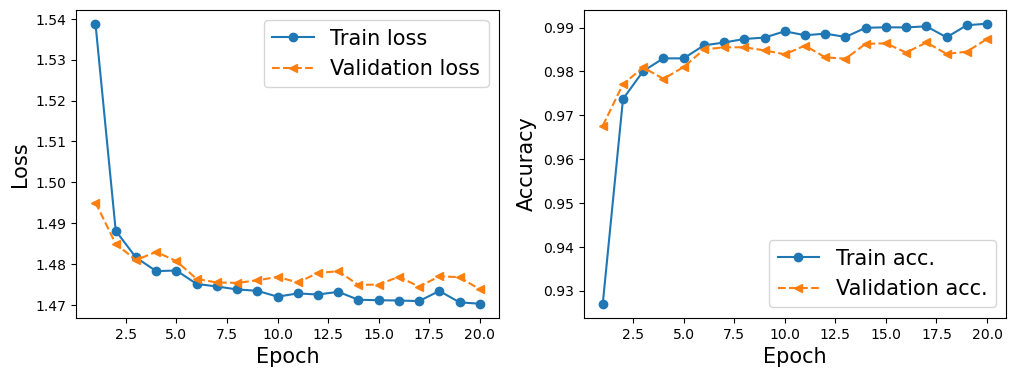

In [9]:
x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

## Tensorboard Monitoring

In [14]:
%load_ext tensorboard
%tensorboard --logdir './runs/MNIST'

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


## Testing

In [11]:
pred = model(mnist_test_dataset.data.unsqueeze(1) / 255.)
is_correct = (torch.argmax(pred, dim=1) == mnist_test_dataset.targets).float()
print(f'Test accuracy: {is_correct.mean():.4f}') 

Test accuracy: 0.9881


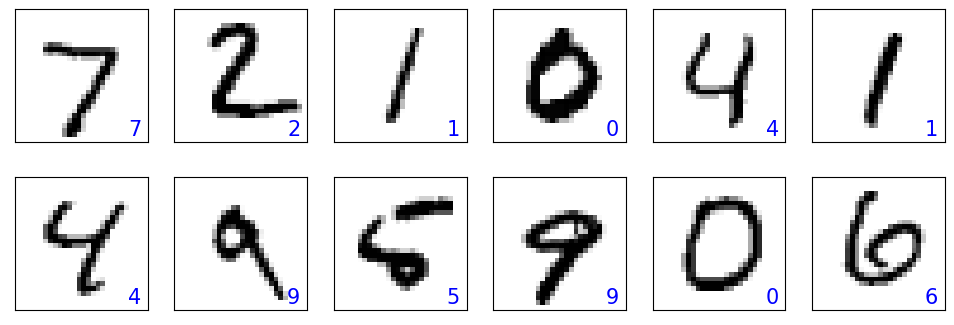

In [12]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    img = mnist_test_dataset[i][0][0, :, :]
    pred = model(img.unsqueeze(0).unsqueeze(1))
    y_pred = torch.argmax(pred)
    ax.imshow(img, cmap='gray_r')
    ax.text(0.9, 0.1, y_pred.item(), 
            size=15, color='blue',
            horizontalalignment='center',
            verticalalignment='center', 
            transform=ax.transAxes)
    
    
plt.show()

## model Saving

In [15]:
path = 'mnist-cnn.ph'
torch.save(model, path)